In [10]:
from netCDF4 import Dataset
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.model_selection import train_test_split

with Dataset("simObsCrossTrack_2dn.nc") as fh:
    yobsL=fh["tb"][:,:]
    x2D=fh["iwc_SSRG"][:,:]
    iwc_CS=fh["iwcCS"][:,:]
    zKu=fh["zKu"][:,:]
    pnorm=fh["pnorm"][:,:]
    #pmol=fh["pmol"][:,:]

nt,nchan=yobsL.shape   
lidarNoise=np.random.randn(nt,50)*0.1
pnorm=np.log10(1e-3*(pnorm*10**lidarNoise+1e-9))
pnormMax=pnorm.max(axis=-1)
nt,nchan=yobsL.shape
lidarEchoPeak=[]
zKuGtL=[]
#print(zKu.shape)
#stop
zKu+=np.random.randn(nt,50)
zKu[zKu<8]=0
# do pca on zKu
from sklearn.decomposition import PCA
bscatter=pnorm[:,30:45]
for i,pnorm1 in enumerate(pnorm):
    lidarEchoPeak.append([np.argmax(pnorm1)*0.24,2*pnorm1.max()])
    z1=zKu[i]
    a=np.nonzero(z1>8)
    z1[z1<8]=0
    if len(a[0])>0:
        zKuGtL.append(z1)
    else:
        zKuGtL.append(z1)
yobsL+=np.random.randn(nt,nchan)*3
zKuGtL=np.array(zKuGtL)
yobsRadiomLidar=np.concatenate((yobsL,pnorm),axis=-1)
yobsRadiomLidarRadar=np.concatenate((yobsL,pnorm,zKuGtL),axis=-1)
ind_train,ind_test,y_train, y_test = train_test_split(range(nt), x2D[:].sum(axis=-1)*0.24, test_size=0.33, random_state=42)
nt,nc=yobsL.shape

X1_train=yobsRadiomLidarRadar[ind_train,:]
X1_test=yobsRadiomLidarRadar[ind_test,:]
iwc_train=x2D[ind_train,:]
iwc_test=x2D[ind_test,:]



In [11]:
import pickle
with open('kmeans_iwc.pklz','rb') as f:
    kmeans_iwc=pickle.load(f)["kmeans_iwc"]

iwcCS_train=iwc_CS[ind_train,:]
iwcCS_test=iwc_CS[ind_test,:]
iwc_float=iwcCS_train[:,:].data.astype(np.float16)
labels_=kmeans_iwc.predict(iwc_float)

(array([37843.,  4639.,  2081.,  8173.,  2953., 12834.,  8217.,  1807.,
        10867.,  3452.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

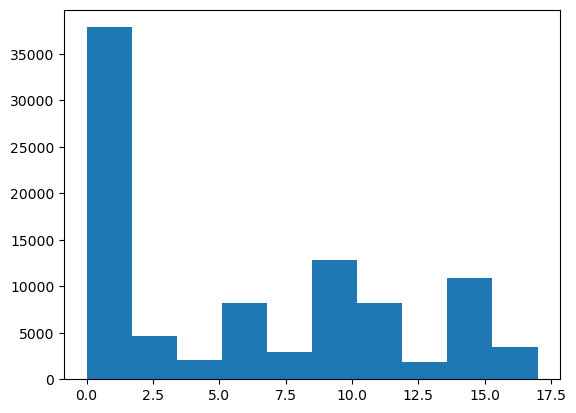

In [12]:
import matplotlib.pyplot as plt
plt.hist(labels_)

In [13]:
nC=18
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

#define tensorflow classifier in keras. use 2 hidden layers and nc=12 output classes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import models
from tensorflow.keras import utils

# define the model

nC=18
def get_model(nC,ninput=10):
    model = keras.Sequential([
        layers.Dense(30, activation='relu', input_shape=[ninput]),
        layers.Dense(30, activation='relu'),
        layers.Dense(nC, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.CategoricalCrossentropy(),
        metrics=['accuracy'])
    return model


model=get_model(nC)
print(model.summary())
# convert to one-hot encoding
y_train_onehot=utils.to_categorical(labels_)
y_test_onehot=utils.to_categorical(kmeans_iwc.predict(iwc_test))
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X1_train)
X_train_scaled=scaler.transform(X1_train)
X_test_scaled=scaler.transform(X1_test)

print(X_train_scaled.shape)
print(X_test_scaled.mean(axis=0))
print(y_train_onehot.shape)
# train the model
history = model.fit(
    X_train_scaled[:,:10], y_train_onehot,
    validation_data=(X_test_scaled[:,:10], y_test_onehot),
    batch_size=32,
    epochs=20,
    verbose=1)

model.save('modelRadiometer.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 30)                330       
                                                                 
 dense_7 (Dense)             (None, 30)                930       
                                                                 
 dense_8 (Dense)             (None, 18)                558       
                                                                 
Total params: 1,818
Trainable params: 1,818
Non-trainable params: 0
_________________________________________________________________
None
(92866, 110)
[ 4.82822109e-03 -2.37859380e-03  3.33324891e-03 -5.05532843e-03
 -1.20866713e-02 -4.78565476e-03 -4.01305753e-03 -1.04586872e-02
 -8.56259443e-03 -9.02201463e-03 -3.05234883e-03 -2.23397072e-03
 -3.13895167e-03 -4.13446419e-03 -3.96030860e-03 -4.35461663e-03
 -4.84970580e-03 -5.33094174e-03 -5.90

In [14]:
iwpC=[]
kgainL=[]
nx=X_train_scaled.shape[1]
xmL=[]
for i in range(nC):
    iwpC.append(kmeans_iwc.cluster_centers_[i,:].sum()*0.24)
    a=np.nonzero(kmeans_iwc.labels_==i)
    xk=X_train_scaled[a[0],:]
    yk=iwc_train[a[0],:]
    covXY=np.cov(xk.T,yk.T)
    covXX=covXY[:nx,:nx]+0.05*np.eye(nx)
    covYX=covXY[nx:,:nx]
    invCovXX=np.linalg.inv(covXX)
    kgain=np.dot(covYX,invCovXX)
    kgainL.append(kgain)
    xmL.append(np.mean(xk,axis=0))

neigh = KNeighborsRegressor(n_neighbors=30,weights='distance')
neigh.fit(X_train_scaled[:,:10], iwc_train.sum(axis=1)*0.24)
iwp_test_neigh=neigh.predict(X_test_scaled[:,:10])
print(iwpC)

[0.08180295758865697, 0.9089434414931393, 1.6821731655012089, 0.480173359889555, 0.9642660480778134, 1.6737403727582874, 0.23640980883686002, 2.0027355312757034, 0.5528023181453682, 0.21693116711461696, 0.5190242172609898, 0.24195421165332084, 1.150682836030796, 3.0904646431690956, 0.18547591360809249, 0.9074943865117198, 0.6241187462041996, 1.809282271247035]


In [8]:
print(covXY.shape)
print(kgainL[0].shape)

(160, 160)
(50, 110)


1430/1430 [==============================] - 0s 301us/step
0.6944010938134966


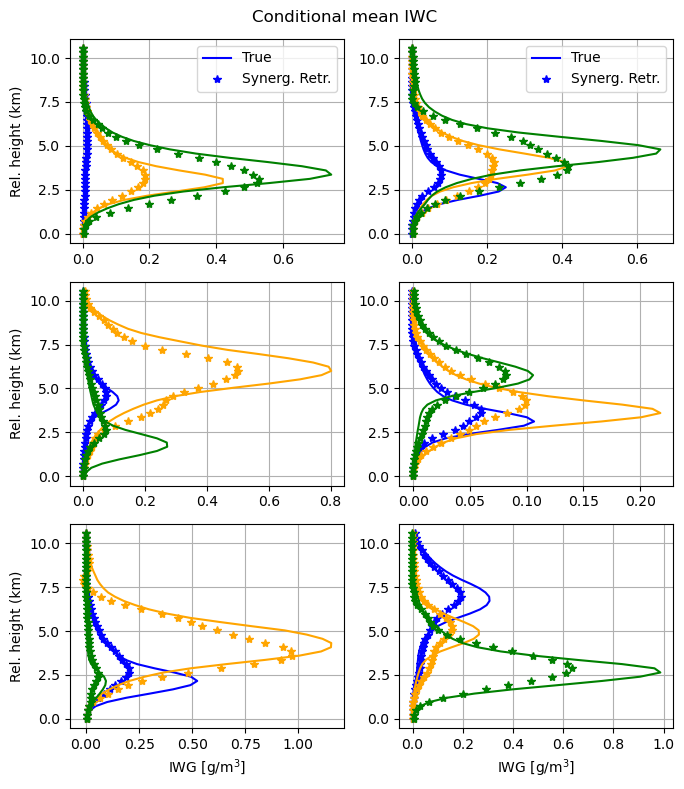

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

nC=18 # number of clusters

iwc_class_=kmeans_iwc.predict(iwc_test)
plt.figure(figsize=(7,8))

iclass=0
cols=['b','orange','g']
ninput=10
class_onehot_=model.predict(X_test_scaled[:,:ninput])
iwcLR_=[]
for i,iwp1_ in enumerate(X_test_scaled):
    iclass=np.argmax(class_onehot_[i,:])
    iwc1=kmeans_iwc.cluster_centers_[iclass,:]+0.975*np.dot(kgainL[iclass],X_test_scaled[i,:]-xmL[iclass])
    iwcLR_.append(iwc1)#/iwc1.sum()/0.24*iwp_test_neigh[i])
iwcLR_=np.array(iwcLR_)
leg1=['True',None,None]
leg2=['Synerg. Retr.',None,None]
iclass=0
for i in range(3):
    for j in range(2):
        ax=plt.subplot(3,2,i*2+j+1)
        if j>0:
            i1=1
            #ax.yaxis.set_visible(False)
            #ax.set_ylabel('')
        else:
            ax.set_ylabel('Rel. height (km)')
        if i==3:
            ax.set_xlabel('IWG [g/m3]')
        #ax.xaxis.set_visible(False)
        for k in range(3):
            a=np.nonzero(iwc_class_==iclass)[0]
            if len(a)>0:
                plt.plot((iwc_test[a,:45]).mean(axis=0),np.arange(0,45)*0.24,color=cols[k],label=leg1[k])
                plt.plot((iwcLR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'*',color=cols[k],label=leg2[k])
                #plt.plot((iwcR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'o',color=cols[k])
            # plot yticks no labels
                ax.set_yticks(np.arange(0,12.5,2.5))
                ax.grid()
            iclass+=1
        if i==2:
            ax.set_xlabel('IWG [g/m$^3$]')
        if i==0:
            plt.legend()
            #ax.set_ylabel('Rel. height (km)')
plt.suptitle('Conditional mean IWC')
plt.tight_layout()
plt.savefig('fig05.rev.png')
def nrms(iwc1,iwc2):
    return np.sqrt(np.mean((iwc1.flatten()-iwc2.flatten())**2))/np.sqrt(np.mean(iwc1.flatten()**2))
print(nrms(iwc_test,iwcLR_))

378.1904814880869 285.34099411387416


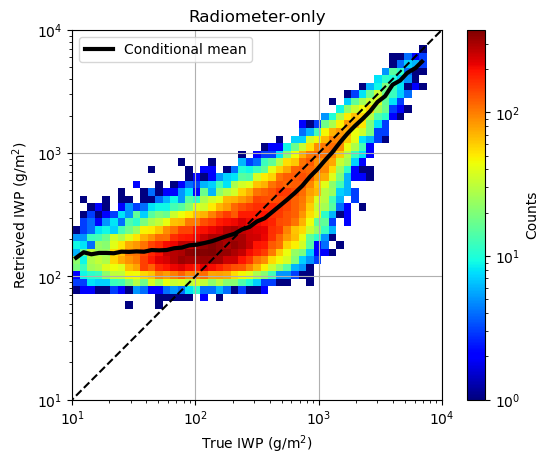

In [18]:
import matplotlib

iwcLR_=np.array(iwcLR_)
iwpLR_=np.sum(iwcLR_,axis=1)*0.24
iwp_test_=np.sum(iwc_test,axis=1)*0.24
xbins=np.logspace(1,4,50)
#plt.figure(figsize=(6,6))
ax=plt.subplot(111)
iwp_hist=plt.hist2d(iwp_test_*1000,iwp_test_neigh*1000,bins=xbins,norm=matplotlib.colors.LogNorm(),cmap='jet')
plt.plot([0.1,1e4],[0.1,1e4],'k--')
truthL=[]
predictionL=[]
for i in range(49):
    a=np.nonzero((iwp_test_*1000>xbins[i]) & (iwp_test_*1000<xbins[i+1]))
    if len(a[0])>0:
        truthL.append(1000*iwp_test_[a].mean())
        predictionL.append(1000*iwp_test_neigh[a].mean())
plt.plot(truthL,predictionL,'k-',linewidth=3,label='Conditional mean')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True IWP (g/m$^2$)")
plt.ylabel("Retrieved IWP (g/m$^2$)")
plt.title('Radiometer-only')
ax.set_aspect('equal')
plt.grid()
cbar=plt.colorbar(iwp_hist[-1])
cbar.set_label('Counts')
plt.savefig('fig04.rev.png')

print(iwp_test_.mean()*1000,iwpLR_.mean()*1000)

(45740, 50)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_19903/2467709946.py:15: RuntimeWarning: invalid value encountered in double_scalars
  hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()


[[1.        0.9501889]
 [0.9501889 1.       ]]


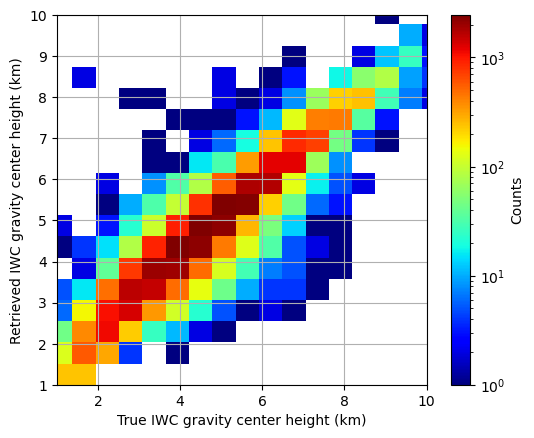

In [19]:
import matplotlib
hgRealL=[]
hgPredL=[]
#print(iwcL_.shape)
print(iwc_test.shape)
for i,iwc1 in enumerate(iwcLR_):
    #hc1=(iwc1*np.arange(50)).sum()*0.24/iwc1.sum()
    #hc2=(iwc_test[i,:]*np.arange(50)).sum()*0.24/iwc_test[i,:].sum()
    a1=np.nonzero(iwc1>0.01)
    hc1=np.argmax(iwc1)*0.24
    hc2=np.argmax(iwc_test[i,:])*0.24
    h=np.arange(50)
    if len(a1[0])>3:
        hc1=(iwc1[a1]*h[a1]).sum()*0.24/iwc1[a1].sum()
        hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()
    #print(hc1,hc2)
    if hc1>0 and hc2>0:
        hgRealL.append(hc2)
        hgPredL.append(hc1)
plt.figure()
ax=plt.subplot(111)
hist2d_=plt.hist2d(hgRealL,hgPredL,bins=20,cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')
plt.grid()
plt.xlabel('True IWC gravity center height (km)')
plt.ylabel('Retrieved IWC gravity center height (km)')
plt.xlim(1,10)
plt.ylim(1,10)
cbar=plt.colorbar(hist2d_[-1])
cbar.set_label('Counts')
plt.savefig('fig06.rev.png')
print(np.corrcoef(hgRealL,hgPredL))

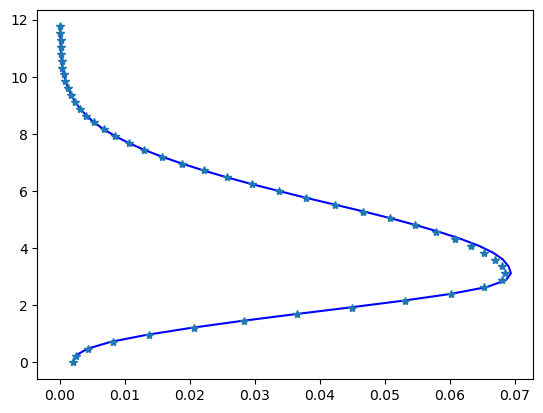

In [54]:
plt.plot(iwc_test.mean(axis=0),np.arange(0,50)*0.24,'b',label='True')
plt.plot(iwcLR_.mean(axis=0),np.arange(0,50)*0.24,'*',label='Retrieved')

In [18]:
print(iwc_.shape)

(92866, 50)
